## Time Series Project
### Author: Michael Murillo

In [1]:
#Importar liberias
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima

In [2]:
#Importamos el dataset
os.chdir(r"C:\Users\micha\OneDrive\Desktop\U\Analisis estadistico\Series Temporales\Ejercicio")
df = pd.read_csv("DatosEjercicio.csv")
df.head()

,Month,Value
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [3]:
#Se usa la columna de fecha como el Index para el dataset
df["Month"] = pd.to_datetime(df["Month"], format="%b-%y", infer_datetime_format= True)
df.index = df["Month"]
del (df["Month"])
df.head()

,Value
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


# Exploracion de datos y visualizacion

## Estacionalidad

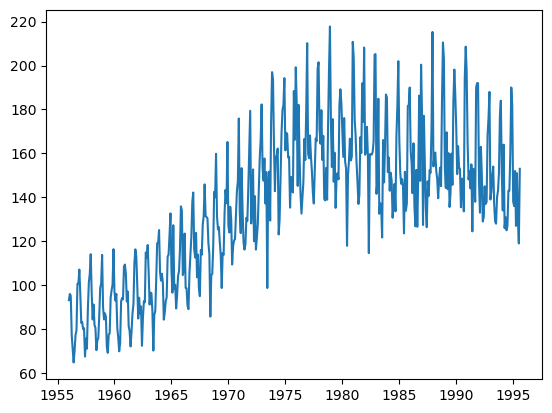

In [4]:
##Graficamos el dataset.
plt.plot(df)

A simple vista se puede observar una serie no estacionaria y sin tendencia. Ademas, se observa una alta varianza a traves de todos los periodos. 

Encontre un metodo para determinar la tendencia el cual consiste en dividir el dataset en secciones (En este caso 4) y comparar las medias de cada uno de estos periodos para determinar si existe un crecimiento o si se mantienen uniformes.

### Particionando los datos

In [5]:
#Convertimos a un array los volumenes del dataset
values = df.values

#Se parte en 4 partes el array
parts = int(len(values) / 4)
part1 = values[0:parts]
part2 = values[parts:(parts*2)]
part3 = values[(parts*2):(parts*3)]
part4 = values[(parts*3):(parts*4)]

#Se extrae la media de cada una de las particiones
mean_1 = part1.mean()
mean_2 = part2.mean()
mean_3 = part3.mean()
mean_4 = part4.mean()
print('mean1=%f, mean2=%f, mean3=%f, mean4=%f' % (mean_1, mean_2, mean_3, mean_4))

mean1=93.787395, mean2=135.465546, mean3=161.035294, mean4=155.293277


Definitivamente se puede observar un crecimiento de la media con cada periodo que agregamos.
Sin embargo, voy a hacer un test de Dickey-Fuller para determinar con exactitud si es estacionaria, en donde tomamos como hipotesis nula que la data NO es estacionaria.]

### KPSS

Para este test, la hipotesis Nula nos indica que la serie es estacionaria.

In [6]:
# KPSS
from statsmodels.tsa.stattools import kpss

KPSS = kpss(df["Value"])

# Mostramos los valores
print('KPSS Statistic: %f' % KPSS[0])
print('p-value: %f' % KPSS[1])


KPSS Statistic: 2.965464
p-value: 0.010000


C:\Users\micha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Rechazamos la hipotesis nula, la serie NO es estacionaria.

### PP

Para este test, la hipotesis Nula nos indica que la serie es estacionaria.

In [7]:
# PP
from arch.unitroot import PhillipsPerron as PP

PP = PP(df["Value"])
PP

Test Statistic,-7.491
P-value,0.000
Lags,18


No tenemos suficiente evidencia estadistica para rechazar H0, en otras palabras es una serie no estacionaria

### ERS

In [8]:
from arch.unitroot import DFGLS

ERS = DFGLS(df["Value"])
ERS

Test Statistic,0.486
P-value,0.834
Lags,17


Una vez mas, el test nos indica que la serie no es estacionaria.

### Augmented Dickey-Fuller Test

In [9]:
from statsmodels.tsa.stattools import adfuller

#Segun la documentacion, cada lag representa un mes. Use un lag de 12 de manera que sea Anual.
adftest = adfuller(df,maxlag=12)

#Extraemos los valores del test de manera que sean legibles.
print('Dickey-Fuller Test Statistic: ', np.round(adftest[0], 6))
print('Dickey-Fuller Test P-Value: ', np.round(adftest[1], 6))

Dickey-Fuller Test Statistic:  -2.379024
Dickey-Fuller Test P-Value:  0.147744


Con un P-Value de 0.14, no tenemos evidencia suficiente para rechazar la hipotesis nula por lo que la data NO es estacionaria.

Si quisieramos tener inclusive mas evidencia sobre si existe estacionalidad, podemos aplicar un decompose para obtener una mejor vision de como se ve el dataset.

### Diferenciación

Segun lo visto en clase, utilizare la libreria pmdarima. La función "ndiffs" intenta nos indica si nuestros datos requieren diferenciacion para poder ser estacionarios.

Un 1 indicaria que nuestros datos requieren una diferenciacion.

In [10]:
pmdarima.arima.ndiffs(df)

1

La función "nsdiffs" muestra el parámetro 1, que determina que los datos si requieren diferenciación estacional. Elegimos 12 como parámetro "m" debido a que nuestros datos son mensuales.


In [11]:
pmdarima.arima.nsdiffs(df, m = 12)

0

Ahora obtenemos un 0 cuando especificamos m = 12. Utilizaremos esta informacion para realizar la diferenciacion

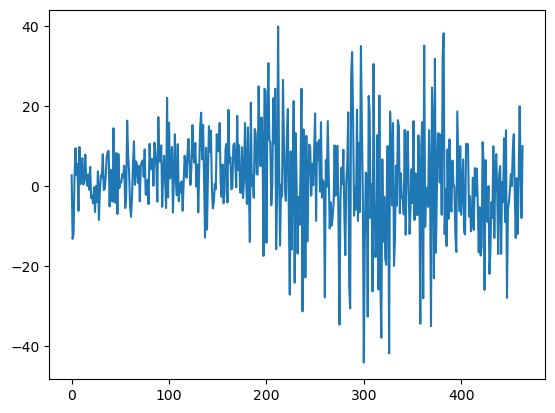

In [12]:
#Para este paso, especificamos un lag = 12 que equivale a los ciclos de nuesta serie temporal y un 1 en diferenciacion.
dfdif = pmdarima.utils.diff(df,lag = 12, differences= 1)

plt.plot(dfdif)

Al emplear la diferenciacion, hemos conseguido una media constante. Ahora necesitamos solucionar la varianza. Para lograr esto, hemos visto un metodo en clase que diferenciar los datos respecto al periodo anterior.


In [13]:
pmdarima.arima.ndiffs(dfdif)
#Obtenemos un 1

1

In [14]:
pmdarima.arima.nsdiffs(dfdif, m = 12)
#Obtenemos un 0

0

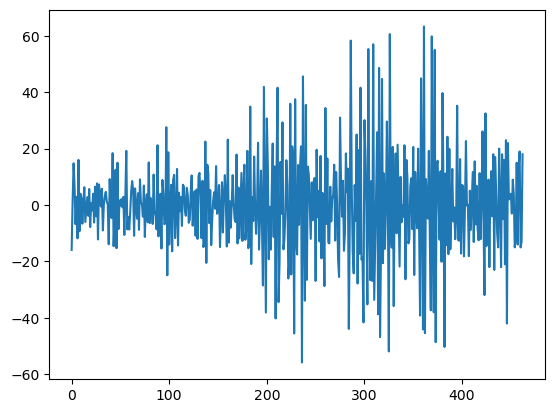

In [15]:
# Recomienda diferenciarlos respecto a la anterior.
dfdif2 = pmdarima.utils.diff(dfdif,lag = 1, differences= 1)

# Graficamos
plt.plot(dfdif2)

Podemos observar que la varianza ha mejorado aunque no tanto. Ademas, parece que esto tambien ha contribuido a mejorar la estacionalidad.
Ahora procedemos a aplicar logaritmos para intentar mejorar la varianza.

### Aplicando logaritmos

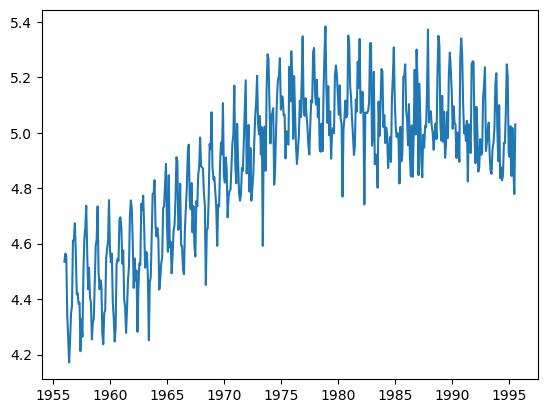

In [16]:
logdf = pd.DataFrame(np.log(df["Value"]))
plt.plot(logdf)

Notamos que aplicar logaritmos por sí solos no resuelve el problema. Aunque se ha resuelto la cuestión de la varianza, todavía es necesario aplicar la diferenciación para determinar si es necesario hacerlo.

In [17]:
pmdarima.arima.ndiffs(logdf)

1

Obtenemos un 1 lo cual indica que debemos de diferenciar!

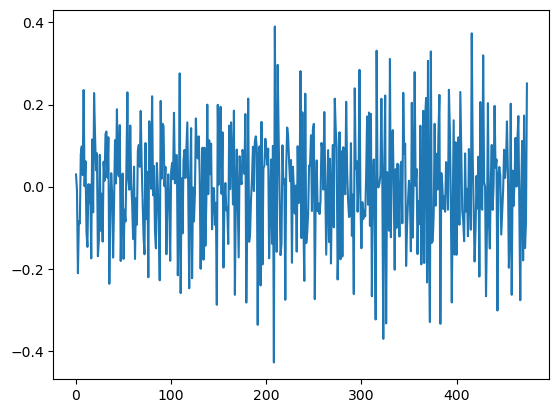

In [18]:
logdfdif = pd.DataFrame(pmdarima.utils.diff(logdf,lag = 1, differences= 1))

# Graficamos
plt.plot(logdfdif)

Hemos logrado mejorar significativamente la varianza en nuestros datos. Después de implementar diversas técnicas de preprocesamiento y análisis, hemos logrado reducir en gran medida la variabilidad de los datos y obtener un conjunto de datos mucho más homogéneo. 

Ahora, con nuestro nuevo set de datos, realizamos de nuevo un Augmented Dickey-Fuller test para determinar si nuestros datos presentan estacionalidad.

In [19]:
adftest2 = adfuller(logdfdif,maxlag=12)

#Extraemos los valores del test de manera que sean legibles.
print('Dickey-Fuller Test Statistic: ', np.round(adftest2[0], 6))
print('Dickey-Fuller Test P-Value: ', np.round(adftest2[1], 6))

Dickey-Fuller Test Statistic:  -15.307653
Dickey-Fuller Test P-Value:  0.0


Con un P-Value de 0.0, rechazamos la hipotesis nula por lo que concluimos que nuestros datos SON estacionales.

AutoArima nos recomienda utilizar un modelo SARIMAX(4, 0, 1)x(2, 0, [1, 2], 12), utilizaremos esto para compararlos resultados al final
con un BIC del 1101

# Decompose

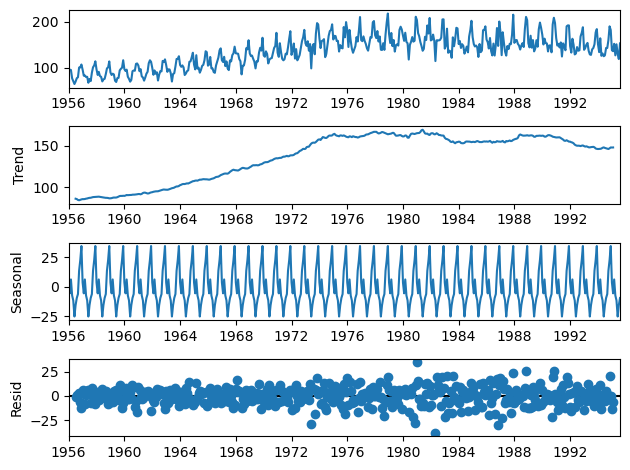

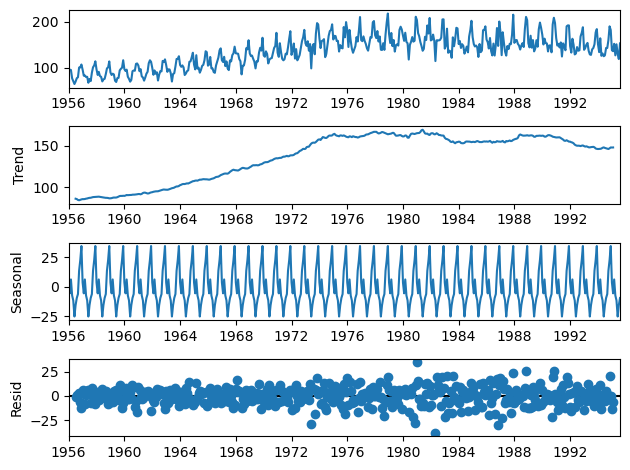

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

# De manera aditiva ¿por que?***************

decomposed_df = seasonal_decompose(df, model='additive')
decomposed_df.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)

En nuestro dataset podemos identificar un crecimiento constante en la tendencia y una estacionalidad presente. Además, se puede notar que la tendencia se mantiene relativamente constante a partir de 1974-1975. 

Restringir la cantidad de datos no siempre afecta negativamente el rendimiento de nuestro modelo. En ocasiones, los datos más antiguos pueden funcionar como ruido.

In [21]:
#228 Es el numero de indice en el que empieza el año 1975
df1= df[228:]
df1

,Value
Month,
1975-01-01,161.4
1975-02-01,169.4
1975-03-01,168.8
1975-04-01,158.1
1975-05-01,158.5
...,...
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0


Volviendo a nuestro dataset original, utilizando la libreria seasonal_decompose, podemos extraer la estacionalidad y tendencia  para substraerla de nuestros valores originales.

#### Serie sin componente estacional

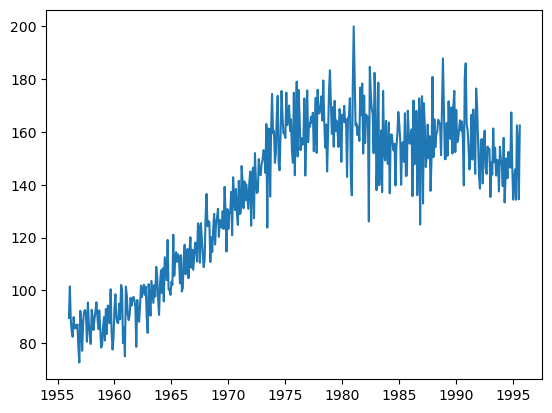

In [22]:
notendency_df = df["Value"] - decomposed_df.seasonal
plt.plot(notendency_df)

#### Serie sin tendencia

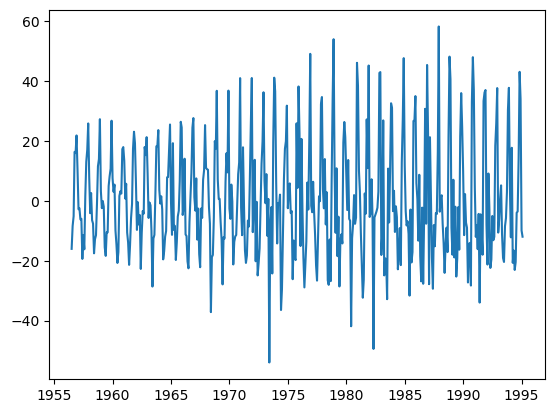

In [23]:
notendency_df = df["Value"] - decomposed_df.trend
resid = df["Value"] - decomposed_df.seasonal - decomposed_df.trend

plt.plot(notendency_df)

#### Serie sin componente aleatoria

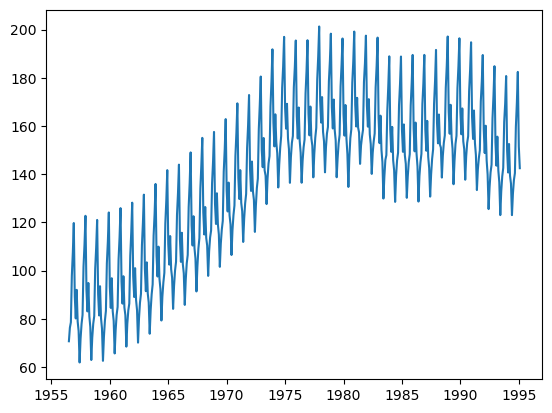

In [24]:
noresid_df = df["Value"] - decomposed_df.resid
plt.plot(noresid_df)

Para lograr una serie más homogenea, hemos implementado una técnica de suavizado mediante el uso de medias móviles. Al aplicar esta metodología, hemos logrado eliminar una parte del ruido.

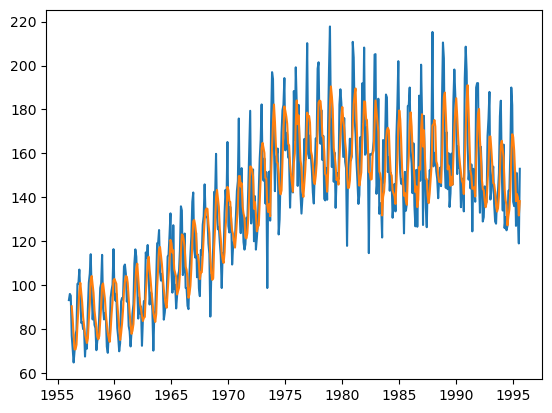

In [25]:
df['mov_avg'] = df['Value'].rolling(4).mean()
plt.plot(df)
df.drop(columns = ['mov_avg'], inplace= True)

Utilizamos suavizado exponencial como metodo de experimentacion para la reduccion del ruido.

Parece ser que descomponiendo no estamos obteniendo resultados positivos, por lo que utilizaremos los datos obtenidos de la funcion logaritmica con diferenciacion (dataset = logdfdif)

## Modelado de datos y fit del modelo

Para comenzar nuestro análisis, procedemos a evaluar la correlación y correlación parcial de nuestros datos

C:\Users\micha\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


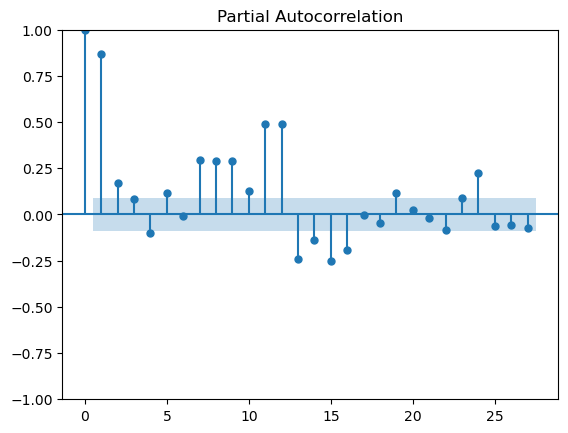

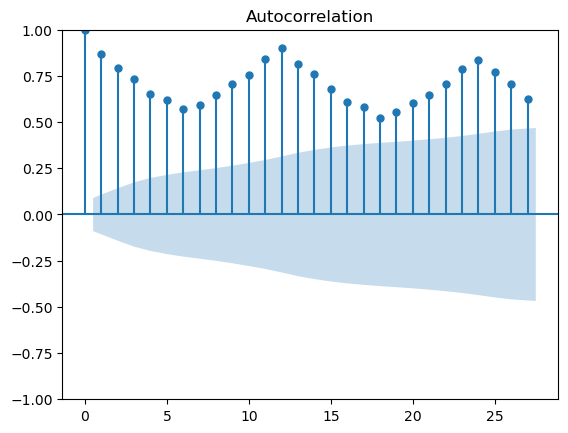

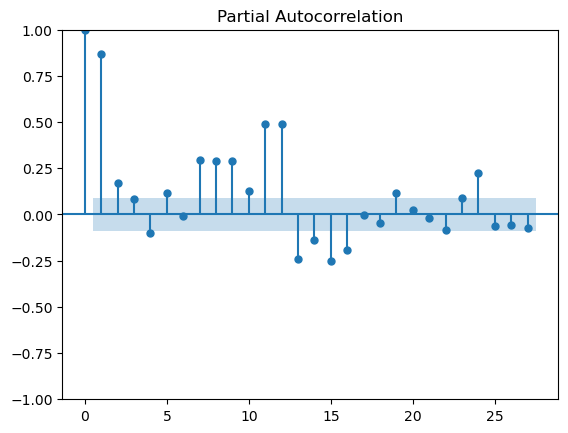

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(logdf)
plot_pacf(logdf)

### Arima

Para nuestro modelo, dividimos nuestros datos en train y test siguiendo la proporcion recomendada de 80 / 20. en este caso, nuestro dataset contiene 475 lineas.

In [27]:
logdf.count()*0.80

Value    380.8
dtype: float64

In [28]:
train = logdf[:380]
test = logdf[381:]

In [29]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(train.iloc[:,0], order=(2,1,1), seasonal_order=(1,0,1,12))

C:\Users\micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [30]:
ArimaModel = model.fit()
print (ArimaModel.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Value   No. Observations:                  380
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 456.195
Date:                            Wed, 22 Feb 2023   AIC                           -900.390
Time:                                    15:19:11   BIC                           -876.765
Sample:                                01-01-1956   HQIC                          -891.015
                                     - 08-01-1987                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1982      0.049     -4.011      0.000      -0.295      -0.101
ar.L2         -0.1592      0.053   

C:\Users\micha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
test["FORECAST"] = ArimaModel.forecast(len(test))
test

C:\Users\micha\AppData\Local\Temp\ipykernel_9544\3027004150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["FORECAST"] = ArimaModel.forecast(len(test))


,Value,FORECAST
Month,,
1987-10-01,5.018603,5.145629
1987-11-01,5.148657,5.144101
1987-12-01,5.372032,5.264005
1988-01-01,5.037602,5.087747
1988-02-01,5.070789,4.989290
...,...,...
1995-04-01,4.844187,4.996831
1995-05-01,5.017280,4.917033
1995-06-01,4.867534,4.845834


In [32]:
test["Value"]  = np.exp(test["Value"])
test["FORECAST"]  = np.exp(test["FORECAST"])
test

C:\Users\micha\AppData\Local\Temp\ipykernel_9544\351610434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Value"]  = np.exp(test["Value"])
C:\Users\micha\AppData\Local\Temp\ipykernel_9544\351610434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["FORECAST"]  = np.exp(test["FORECAST"])


,Value,FORECAST
Month,,
1987-10-01,151.2,171.679409
1987-11-01,172.2,171.417297
1987-12-01,215.3,193.253956
1988-01-01,154.1,162.024341
1988-02-01,159.3,146.832096
...,...,...
1995-04-01,127.0,147.943635
1995-05-01,151.0,136.596666
1995-06-01,130.0,127.209392


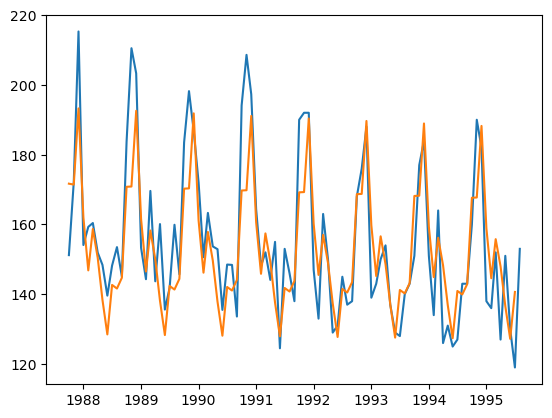

In [33]:
plt.plot(test)

Los resultados parecen ser bastante positivos. Se puede apreciar un forecast bastante ajustado a los valores reales y con capacidad de prevenir la estacionalidad.

### AutoArima (Resultados)

In [34]:
AutoArimaModel = pmdarima.auto_arima(train, error_action='ignore', seasonal=True, m=12)
AutoArimaModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  380
Model:             SARIMAX(1, 1, 3)x(2, 0, [1, 2], 12)   Log Likelihood                 455.755
Date:                                 Wed, 22 Feb 2023   AIC                           -891.511
Time:                                         15:19:45   BIC                           -852.135
Sample:                                     01-01-1956   HQIC                          -875.885
                                          - 08-01-1987                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.246e-05   7.89e-05      0.285      0.776      -0.000       0.000
ar.L1         -0.4544      0.222     -2.044      0.041      -0.890      -0.019
ma.L1         -0.6110      0.220     -2.783      0.005      -1.041      -0.181
ma.L2         -0.5098      0.222     -2.295      0.022      -0.945      -0.074
ma.L3          0.2147      0.050      4.266      0.000       0.116       0.313
ar.S.L12       0.2478      0.181      1.372      0.170      -0.106       0.602
ar.S.L24       0.7283      0.177      4.124      0.000       0.382       1.074
ma.S.L12       0.1113      0.172      0.648      0.517      -0.225       0.448
ma.S.L24      -0.6077      0.107     -5.661      0.000      -0.818      -0.397
sigma2         0.0049      0.000     15.454      0.000       0.004       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                30.70
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
test['AutoArima'] = AutoArimaModel.predict(len(test))
test

C:\Users\micha\AppData\Local\Temp\ipykernel_9544\1429946207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['AutoArima'] = AutoArimaModel.predict(len(test))


,Value,FORECAST,AutoArima
Month,,,
1987-10-01,151.2,171.679409,5.141524
1987-11-01,172.2,171.417297,5.110014
1987-12-01,215.3,193.253956,5.279980
1988-01-01,154.1,162.024341,5.106401
1988-02-01,159.3,146.832096,4.957564
...,...,...,...
1995-04-01,127.0,147.943635,4.995846
1995-05-01,151.0,136.596666,4.913745
1995-06-01,130.0,127.209392,4.849997


In [36]:
test["AutoArima"]  = np.exp(test["AutoArima"])

C:\Users\micha\AppData\Local\Temp\ipykernel_9544\505580582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["AutoArima"]  = np.exp(test["AutoArima"])


In [37]:
test

,Value,FORECAST,AutoArima
Month,,,
1987-10-01,151.2,171.679409,170.976184
1987-11-01,172.2,171.417297,165.672627
1987-12-01,215.3,193.253956,196.365912
1988-01-01,154.1,162.024341,165.075144
1988-02-01,159.3,146.832096,142.246867
...,...,...,...
1995-04-01,127.0,147.943635,147.797919
1995-05-01,151.0,136.596666,136.148377
1995-06-01,130.0,127.209392,127.739974


Calculemos los errores de los dos modelos:

In [38]:
import sklearn.metrics as metrics

#Eliminamos los nulos del ultimo periodo para evitar errores
test = test.dropna()
mae = metrics.mean_absolute_error(test['Value'], test['FORECAST'])
mse = metrics.mean_squared_error(test['Value'], test['FORECAST'])
rmse = np.sqrt(mse) 

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
 

Results of sklearn.metrics:
MAE: 9.469008808324649
MSE: 156.25200079065615
RMSE: 12.500080031370045


In [39]:
mae = metrics.mean_absolute_error(test['Value'], test['AutoArima'])
mse = metrics.mean_squared_error(test['Value'], test['AutoArima'])
rmse = np.sqrt(mse) 

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
 

Results of sklearn.metrics:
MAE: 9.87354264242045
MSE: 170.81747990016407
RMSE: 13.069716136939014


En los dos modelos podemos apreciar indicadores muy parecidos, sin embargo, el modelo calculado por nosotros posee menores indicadores de error que el autoarima.

Seguiremos analizando mas a fondo los resultados de nuestro modelo:

## Analisis de residuos

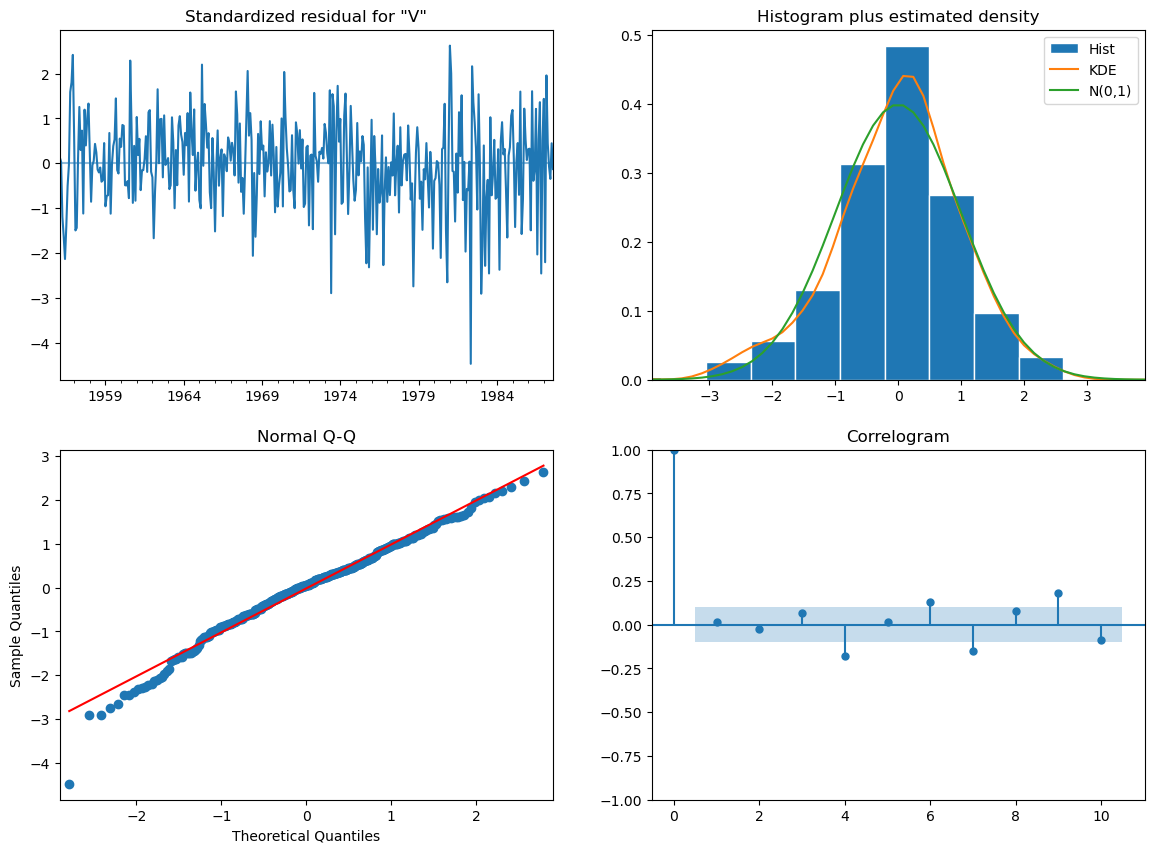

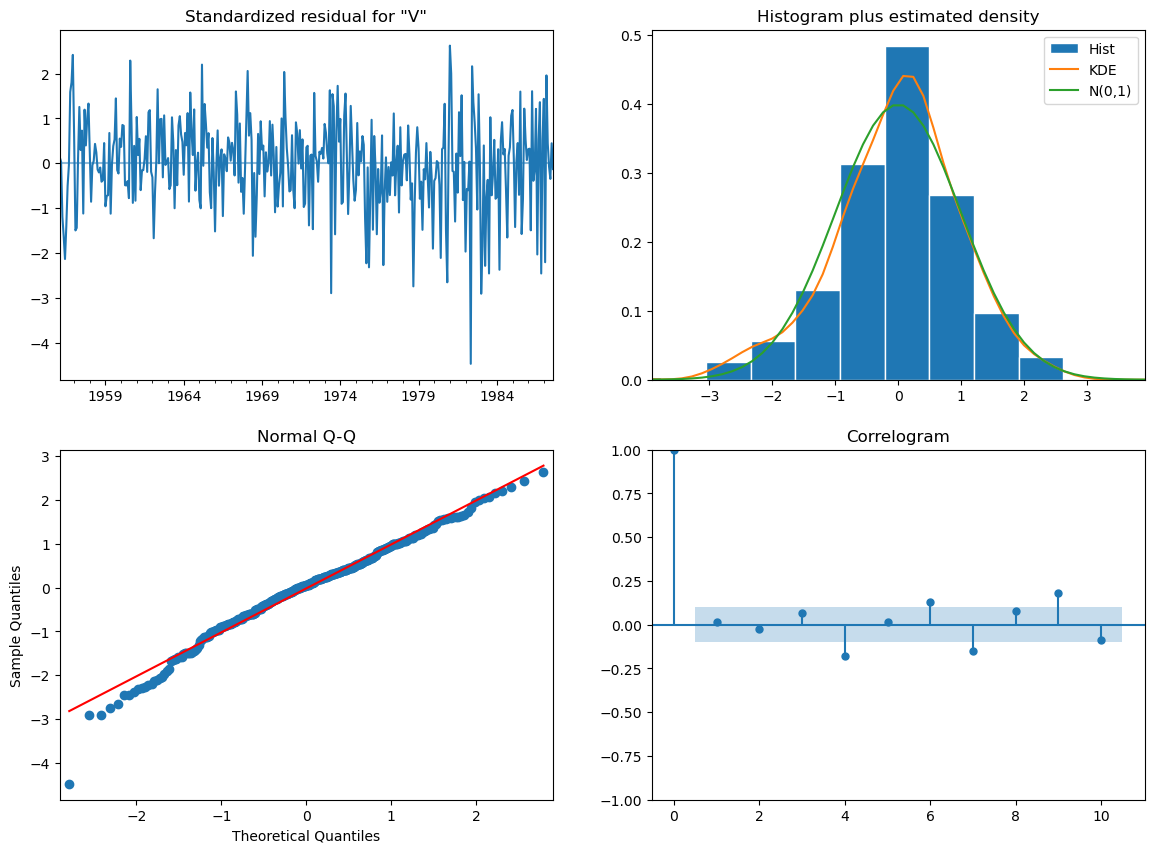

In [40]:
ArimaModel.plot_diagnostics(figsize = (14,10))

C:\Users\micha\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


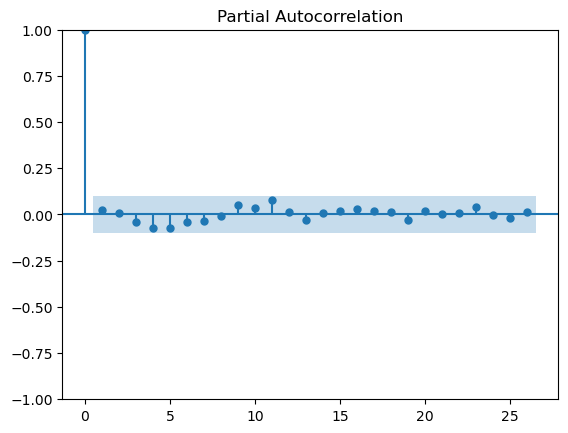

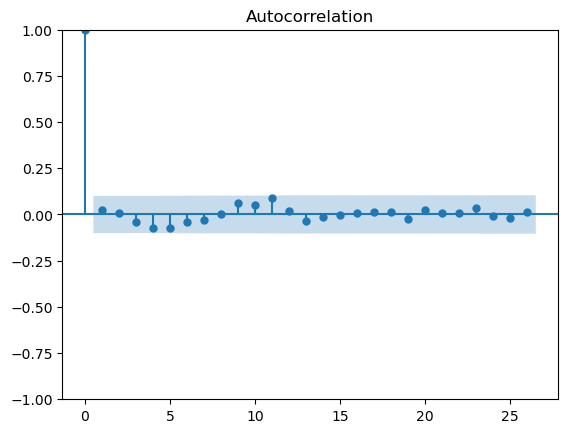

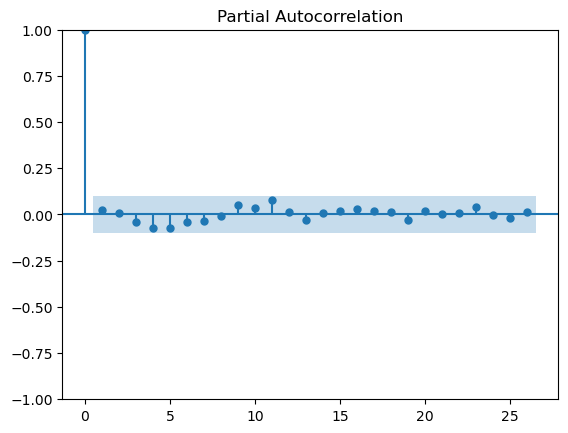

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ArimaModel.resid)
plot_pacf(ArimaModel.resid)

Basandonos en la visualizacion anterior, es seguro afirmar que nuestro modelo ha tenido un buen rendimiento ya que los residuos se encuentran dentro de la media.

Hay varias autocorrelaciones que no son cero de manera significativa. Esto indica que la serie temporal no es aleatoria.